<a href="https://colab.research.google.com/github/michelmalki/MichelMalki/blob/main/Spark_MLlib.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 4.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488491 sha256=c85e6d371ce24dc3a9e3995d8336c931cf4273faff3015e779b2cb99e663ac53
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark


In [22]:
from pyspark.sql import SparkSession

# Create a SparkSession
spark = SparkSession.builder.appName("SentimentAnalysis").getOrCreate()
tweet_schema = "id int, label double, tweet string"
tweets_df = spark.read.csv("sentiment_analysis.csv", header=True, schema=tweet_schema)
tweets_df.show()

+---+-----+--------------------+
| id|label|               tweet|
+---+-----+--------------------+
|  1|  0.0|#fingerprint #Pre...|
|  2|  0.0|Finally a transpa...|
|  3|  0.0|We love this! Wou...|
|  4|  0.0|I'm wired I know ...|
|  5|  1.0|What amazing serv...|
|  6|  1.0|iPhone software u...|
|  7|  0.0|Happy for us .. #...|
|  8|  0.0|New Type C charge...|
|  9|  0.0|Bout to go shoppi...|
| 10|  0.0|Photo: #fun #self...|
| 11|  1.0|hey #apple when y...|
| 12|  1.0|Ha! Not heavy mac...|
| 13|  1.0|Contemplating giv...|
| 14|  0.0|I just made anoth...|
| 15|  1.0|@shaqlockholmes @...|
| 16|  0.0|From #DeepEllum t...|
| 17|  0.0|Like and Share if...|
| 18|  0.0|Go crazy !! #ipho...|
| 19|  1.0|The reason I don'...|
| 20|  1.0|How is the apple ...|
+---+-----+--------------------+
only showing top 20 rows



In [23]:
training_data, test_data = tweets_df.randomSplit([0.8, 0.2], seed=33)

print('Training Data: ', training_data.count())
print('Test data: ', test_data.count())

Training Data:  6260
Test data:  1660


In [28]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import Tokenizer, HashingTF, IDF
from pyspark.ml.classification import LogisticRegression

# from our tweet, create a list of works (tokens)
tokenizer = Tokenizer(inputCol="tweet", outputCol="words")
wordsData = tokenizer.transform(training_data)
display(wordsData.head(5))

[Row(id=1, label=0.0, tweet='#fingerprint #Pregnancy Test https://goo.gl/h1MfQV #android #apps #beautiful #cute #health #igers #iphoneonly #iphonesia #iphone', words=['#fingerprint', '#pregnancy', 'test', 'https://goo.gl/h1mfqv', '#android', '#apps', '#beautiful', '#cute', '#health', '#igers', '#iphoneonly', '#iphonesia', '#iphone']),
 Row(id=3, label=0.0, tweet='We love this! Would you go? #talk #makememories #unplug #relax #iphone #smartphone #wifi #connect... http://fb.me/6N3LsUpCu', words=['we', 'love', 'this!', 'would', 'you', 'go?', '#talk', '#makememories', '#unplug', '#relax', '#iphone', '#smartphone', '#wifi', '#connect...', 'http://fb.me/6n3lsupcu']),
 Row(id=4, label=0.0, tweet="I'm wired I know I'm George I was made that way ;) #iphone #cute #daventry #home http://instagr.am/p/Li_5_ujS4k/", words=["i'm", 'wired', 'i', 'know', "i'm", 'george', 'i', 'was', 'made', 'that', 'way', ';)', '#iphone', '#cute', '#daventry', '#home', 'http://instagr.am/p/li_5_ujs4k/']),
 Row(id=5, la

In [29]:


# map the sequence of words to their term frequency
hashing_term_frequency = HashingTF(inputCol="words", outputCol="rawFeatures", numFeatures=20)

# calculate the IDF for each TF mapping (i.e. how rare is that term in the whole dataset?)
inverse_doc_frequency = IDF(inputCol="rawFeatures", outputCol="features")

# Create a new logistic regression object for the model
log_regression_model = LogisticRegression(maxIter=10, regParam=0.3, labelCol = 'label')

# Construct pipeline, and fit to training data
lr_pipeline = Pipeline(stages=[tokenizer, hashing_term_frequency, inverse_doc_frequency, log_regression_model]).fit(training_data)


/usr/local/lib/python3.10/dist-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


Area under ROC = 0.7270763114683261


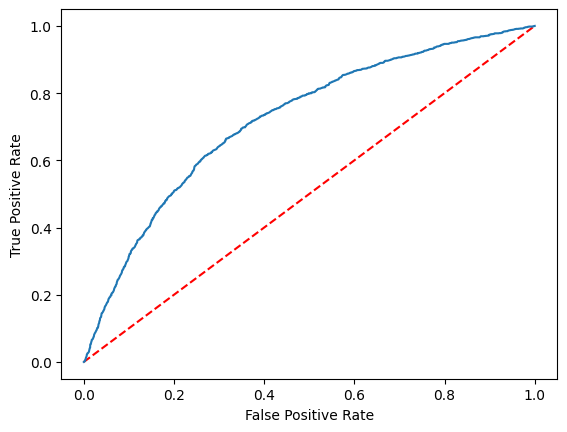

In [26]:
from pyspark.mllib.evaluation import BinaryClassificationMetrics

def test_and_viz(lr_pipeline):

    # model evaluation
    predictions = lr_pipeline.transform(test_data)
    predictionAndLabels = predictions.select("label", "prediction").rdd
    metrics = BinaryClassificationMetrics(predictionAndLabels)
    print("Area under ROC = %s" % metrics.areaUnderROC)

    import matplotlib.pyplot as plt
    ## Plot the ROC curve; no need for pandas, because this uses the modelSummary object
    modelSummary = lr_pipeline.stages[-1].summary

    plt.plot([0, 1], [0, 1], 'r--')
    plt.plot(modelSummary.roc.select('FPR').collect(),
            modelSummary.roc.select('TPR').collect())
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.show()

test_and_viz(lr_pipeline)